In [60]:
import xarray
import rioxarray
import numpy
import matplotlib.pyplot as plt

In [2]:
signatures = rioxarray.open_rasterio("../../urbangrammar_samba/spatial_signatures/signatures/signatures_raster.tif")

In [28]:
signatures

<xarray.DataArray (band: 1, y: 12150, x: 6505)>
array([[[nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan],
        ...,
        [nan, nan, ..., nan, nan],
        [nan, nan, ..., nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * y            (y) float64 1.22e+06 1.22e+06 1.22e+06 ... 5.45e+03 5.35e+03
  * x            (x) float64 5.563e+03 5.663e+03 ... 6.559e+05 6.56e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:    nan
    scale_factor:  1.0
    add_offset:    0.0
    long_name:     signature_type
    grid_mapping:  spatial_ref

In [21]:
unique = numpy.unique(signatures[0])
unique = unique[~numpy.isnan(unique)]

In [22]:
unique

array([ 0., 10., 20., 21., 22., 30., 40., 50., 60., 70., 80., 90., 91.,
       92., 93., 94., 95., 96., 97., 98.])

In [56]:
outliers = [93, 96, 97, 98]
unique = unique[~numpy.isin(unique, outliers)]

In [48]:
total_by_row = signatures[0].count("x")
total_by_col = signatures[0].count("y")

In [57]:
types = {
    0: "Countryside agriculture",
    10: "Accessible suburbia",
    30: "Open sprawl",
    40: "Wild countryside",
    50: "Warehouse/Park land",
    60: "Gridded residential quarters",
    70: "Urban buffer",
    80: "Disconnected suburbia",
    20: "Dense residential neighbourhoods",
    21: "Connected residential neighbourhoods",
    22: "Dense urban neighbourhoods",
    90: "Local urbanity",
    91: "Concentrated urbanity",
    92: "Regional urbanity",
    94: "Metropolitan urbanity",
    95: "Hyper concentrated urbanity",
}

In [58]:
proportion_by_lat = {}
proportion_by_lon = {}

for label in unique:
    proportion_by_lat[types[label]] = ((signatures[0] == label).sum("x") / total_by_row)
    proportion_by_lon[types[label]] = ((signatures[0] == label).sum("y") / total_by_col)

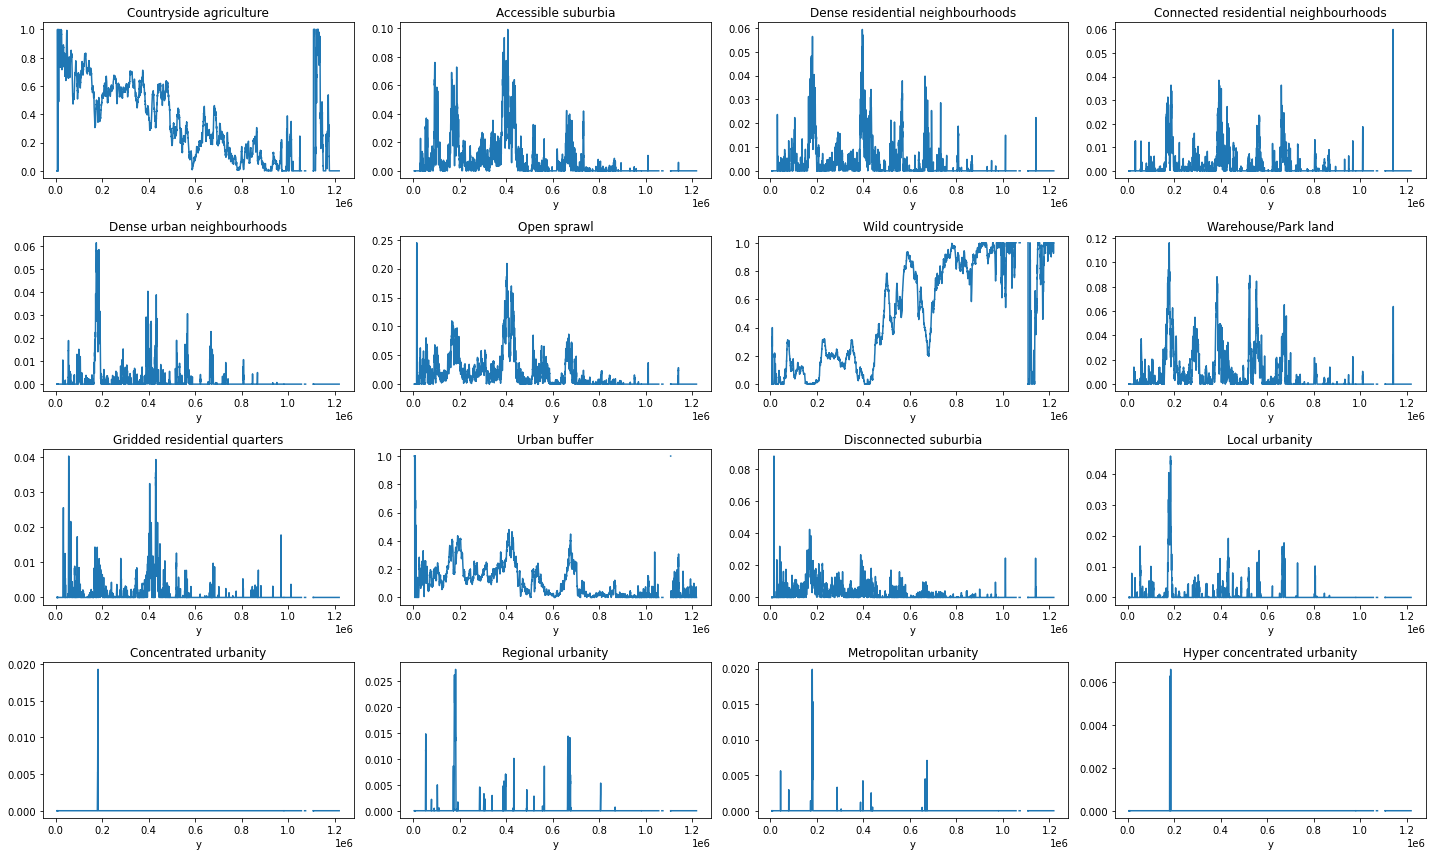

In [71]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for label, ax in zip(proportion_by_lat, axs.flatten()):
    proportion_by_lat[label].plot(ax=ax)
    ax.set_title(label)
plt.tight_layout()

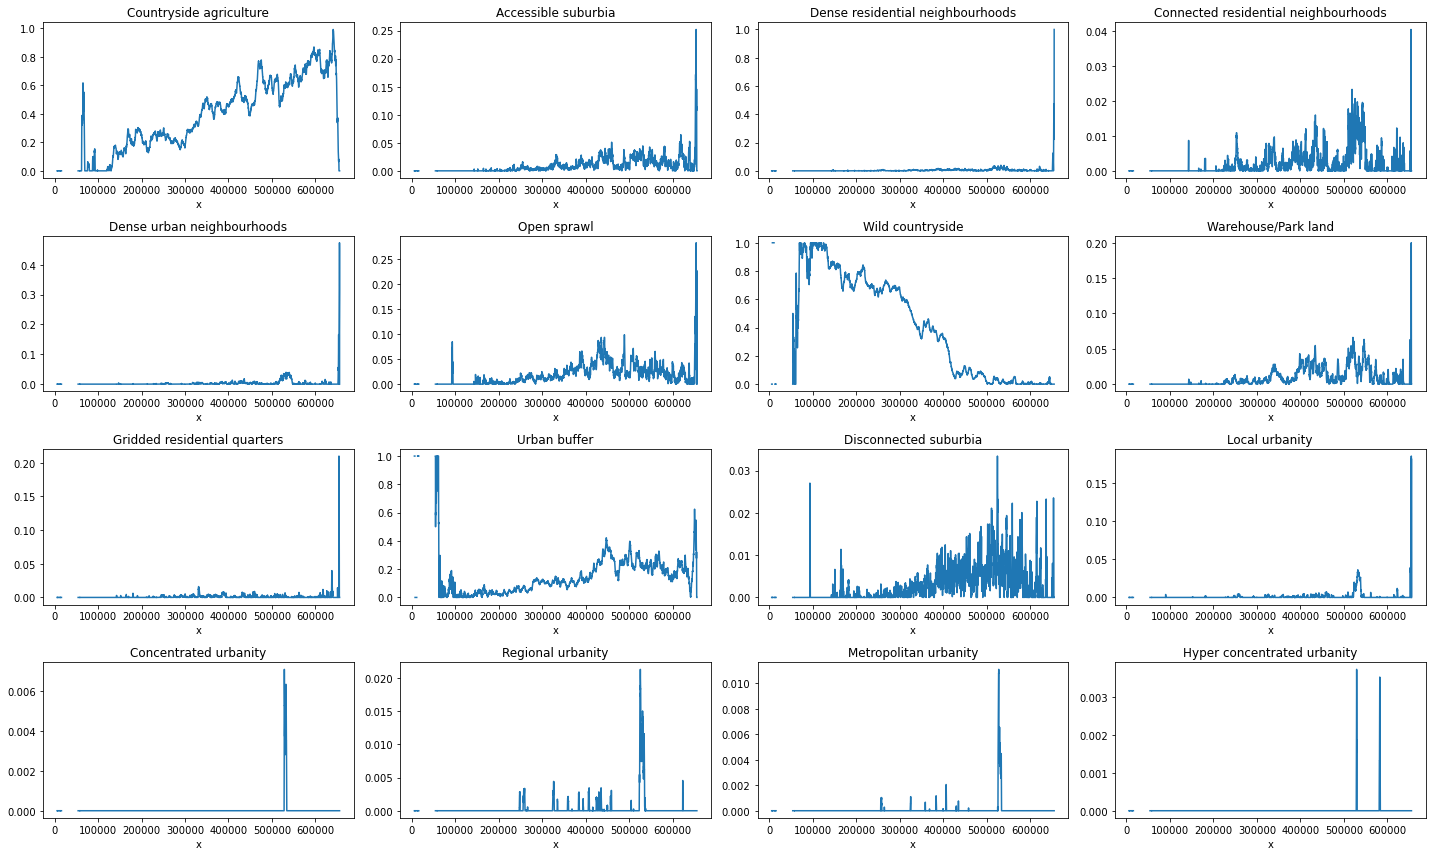

In [73]:
fig, axs = plt.subplots(4, 4, figsize=(20, 12))

for label, ax in zip(proportion_by_lon, axs.flatten()):
    proportion_by_lon[label].plot(ax=ax)
    ax.set_title(label)
plt.tight_layout()